In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pymongo import MongoClient
from nltk.corpus import stopwords
from sklearn import model_selection
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from pymystem3 import Mystem
from string import punctuation

In [3]:
client = MongoClient()
db = client.opinions_db
collection = db.opinions

In [4]:
data = []
for value in collection.find():
    data.append([value['rate'], value['advantages'], value['disadvantages'], value['comment']])
columns = ['rate', 'advantages', 'disadvantages', 'comment']

In [5]:
df = pd.DataFrame(data, columns=columns)
df.head()

,rate,advantages,disadvantages,comment
0,5,Быстрый Удобный в пользовании Быстрый FaceID В...,На задней панели остается очень много отпечатк...,Это мой первый iOS смартфон. И после трех неде...
1,5,"дизайн, корпус, айОС, долговечность, надёжност...","камера сильно выступает из корпуса, придется д...",Покупкой полностью доволен!!!
2,5,"Приятный цвет, удобно лежит в руке. Существенн...",Нужен чехол для неаккуратный людей. Так как ст...,Купил для девушки. Всем довольна. Нареканий не...
3,5,"-Процессор А12 бионик. очень быстрый, приложен...",-Скользкий. ВНИМАНИЕ Руки автора отзыва могут ...,До Xr пользовался 5S. Разница колоссальная во ...
4,5,- Очень живучая батарея. Это первый мой iPhone...,- Все пишут про 3D touch. Я тоже напишу. Его н...,Apple выпустила еще одну модель про которую ещ...


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1640 entries, 0 to 1639
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   rate           1640 non-null   int64 
 1   advantages     1640 non-null   object
 2   disadvantages  1640 non-null   object
 3   comment        1640 non-null   object
dtypes: int64(1), object(3)
memory usage: 51.4+ KB


<AxesSubplot:>

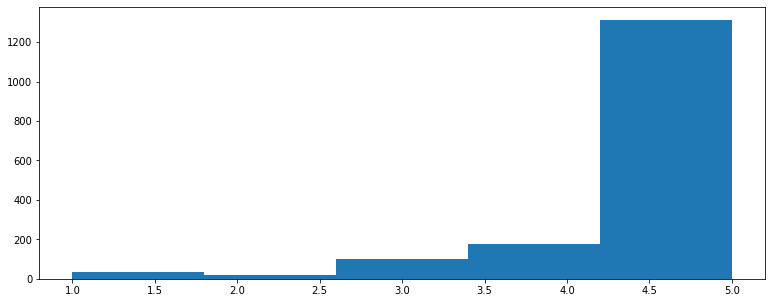

In [7]:
df['rate'].hist(grid=False, bins=5, figsize=(13, 5))

In [8]:
df['text'] = df['advantages'] + ' ' + df['disadvantages'] + ' ' + df['comment']
df.head()

,rate,advantages,disadvantages,comment,text
0,5,Быстрый Удобный в пользовании Быстрый FaceID В...,На задней панели остается очень много отпечатк...,Это мой первый iOS смартфон. И после трех неде...,Быстрый Удобный в пользовании Быстрый FaceID В...
1,5,"дизайн, корпус, айОС, долговечность, надёжност...","камера сильно выступает из корпуса, придется д...",Покупкой полностью доволен!!!,"дизайн, корпус, айОС, долговечность, надёжност..."
2,5,"Приятный цвет, удобно лежит в руке. Существенн...",Нужен чехол для неаккуратный людей. Так как ст...,Купил для девушки. Всем довольна. Нареканий не...,"Приятный цвет, удобно лежит в руке. Существенн..."
3,5,"-Процессор А12 бионик. очень быстрый, приложен...",-Скользкий. ВНИМАНИЕ Руки автора отзыва могут ...,До Xr пользовался 5S. Разница колоссальная во ...,"-Процессор А12 бионик. очень быстрый, приложен..."
4,5,- Очень живучая батарея. Это первый мой iPhone...,- Все пишут про 3D touch. Я тоже напишу. Его н...,Apple выпустила еще одну модель про которую ещ...,- Очень живучая батарея. Это первый мой iPhone...


In [9]:
mystem = Mystem()
STOPWORDS = stopwords.words('russian')

def preprocess_text(text):
    tokens = mystem.lemmatize(text)
    return ' '.join([token for token in tokens if token not in STOPWORDS\
           and token != ' '\
           and token.strip() not in punctuation\
           and not token.isnumeric()\
           and token != '\xa0— '\
           and '«' not in token and '»' not in token])

df['text'] = [preprocess_text(text) for text in df['text']]

In [10]:
df.head()

,rate,advantages,disadvantages,comment,text
0,5,Быстрый Удобный в пользовании Быстрый FaceID В...,На задней панели остается очень много отпечатк...,Это мой первый iOS смартфон. И после трех неде...,быстрый удобный пользование быстрый FaceID впо...
1,5,"дизайн, корпус, айОС, долговечность, надёжност...","камера сильно выступает из корпуса, придется д...",Покупкой полностью доволен!!!,дизайн корпус айос долговечность надежность бе...
2,5,"Приятный цвет, удобно лежит в руке. Существенн...",Нужен чехол для неаккуратный людей. Так как ст...,Купил для девушки. Всем довольна. Нареканий не...,приятный цвет удобно лежать рука существенно ш...
3,5,"-Процессор А12 бионик. очень быстрый, приложен...",-Скользкий. ВНИМАНИЕ Руки автора отзыва могут ...,До Xr пользовался 5S. Разница колоссальная во ...,процессор А12 бионика очень быстрый приложение...
4,5,- Очень живучая батарея. Это первый мой iPhone...,- Все пишут про 3D touch. Я тоже напишу. Его н...,Apple выпустила еще одну модель про которую ещ...,очень живучий батарея это первый iPhone живучи...


In [10]:
# Here by some reason the kernel dies, so maybe I'll return to it later
# pos_cloud = WordCloud(width=3000, 
#                       height=2000, 
#                       random_state=1
#                      ).generate(''.join(df.loc[df['rate'] >= 4]['text']))
# neg_cloud = WordCloud(width=3000, 
#                       height=2000, 
#                       random_state=1
#                      ).generate(''.join(df.loc[df['rate'] < 3]['text']))
# fig, axes = plt.subplots(1, 2, figsize=(5, 5))
# axes[0].imshow(pos_cloud)
# axes[0].axis('off')
# axes[1].imshow(neg_cloud)
# axes[1].axis('off')

In [19]:
Y = np.array([0 if rate <= 3 else 1 for rate in df['rate']])
train_x, test_x, train_y, test_y = model_selection.train_test_split(df['text'], Y)

In [20]:
print(train_y.shape, test_y.shape)

(1230,) (410,)


(array([ 40.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 370.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

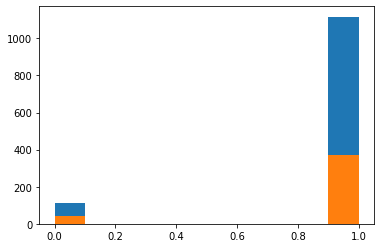

In [21]:
fig, axes = plt.subplots(1, 1)
axes.hist(train_y)
axes.hist(test_y)

In [22]:
# COUNT VECTORS
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(train_x)

xtrain_count = count_vect.transform(train_x)
xtest_count = count_vect.transform(test_x)

In [23]:
xtrain_count

<1230x7269 sparse matrix of type '<class 'numpy.int64'>'
	with 55357 stored elements in Compressed Sparse Row format>

In [ ]:
model = MultinomialNB()
model.fit()